In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///resource/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
columns = inspector.get_columns("measurement")
for c in columns:
    print(c["name"], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
columns = inspector.get_columns("station")
for c in columns:
    print(c["name"], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last12month = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
#last12month

# Calculate the date 1 year ago from the last data point in the database
lastyear = dt.datetime.strptime(last12month, "%Y-%m-%d") - dt.timedelta(days=365)
#lastyear

# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date, func.avg(Measurement.prcp)]
prcpdata = session.query(*sel).filter(Measurement.date >= lastyear).group_by(Measurement.date).all()
#prcpdata

# Save the query results as a Pandas DataFrame and set the index to the date column
prcpdata_df = pd.DataFrame(prcpdata, columns=["Date", "Precipitiation"])
prcpdata_df.set_index("Date", inplace=True)
#prcpdata_df

# Sort the dataframe by date
#why is this needed if we already did groupby earlier?
prcpdata_df = prcpdata_df.sort_values("Date", ascending=True)
prcpdata_df.head()

,Precipitiation
Date,
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000
2016-08-28,0.516667


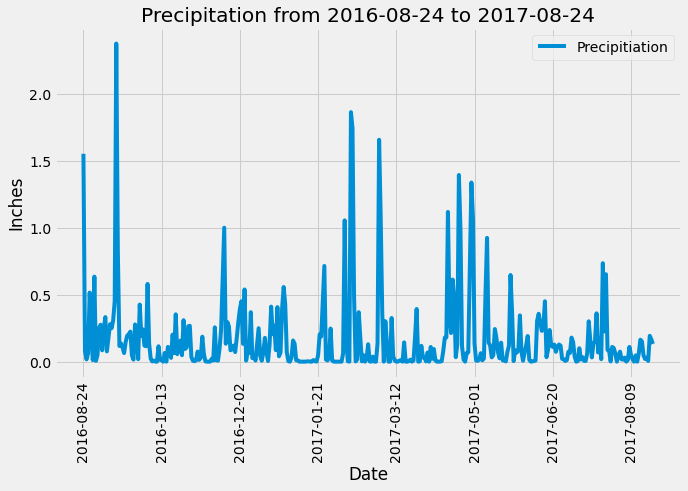

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
prcpdata_df.plot(figsize=(10,6))
plt.title("Precipitation from 2016-08-24 to 2017-08-24")
plt.ylabel("Inches")
plt.xticks(rotation="vertical")
plt.show()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcpdata_df.describe()

,Precipitiation
count,365.000000
mean,0.169987
std,0.295722
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


In [16]:
# Design a query to show how many stations are available in this dataset?
stationcount = session.query(Station.id).count()
print(f"{stationcount} stations present on the Stations data.")

9 stations present on the Stations data.


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
activestation = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
activestation

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
tempdata_active = session.query(*sel).filter(Measurement.station == activestation[0][0]).all()
#tempdata_active
print(f"Most Active Station ({activestation[0][0]}) Data:")
print(f" Lowest temperature = {tempdata_active[0][0]}")
print(f"Highest temperature = {tempdata_active[0][1]}")
print(f"Average temperature = {tempdata_active[0][2]}")

Most Active Station (USC00519281) Data:
 Lowest temperature = 54.0
Highest temperature = 85.0
Average temperature = 71.66378066378067


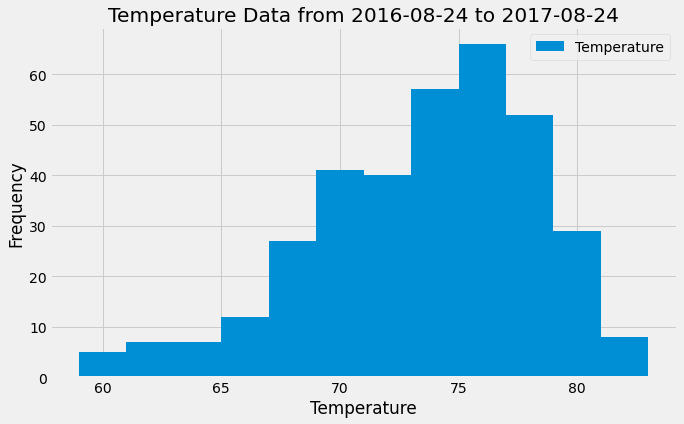

In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobsobserve = session.query(Measurement.tobs).filter(Measurement.station == activestation[0][0]).\
    filter(Measurement.date >= lastyear).all()

tobsobserve_df = pd.DataFrame(tobsobserve, columns=["Temperature"])
tobsobserve_df.plot(kind="hist", bins=12, figsize=(10,6))
plt.title("Temperature Data from 2016-08-24 to 2017-08-24")
plt.xlabel("Temperature")
plt.show()

## Bonus Challenge Assignment

In [29]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [37]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# thanks to covid-19, we really cannot travel...
# but I will use 2017 data since that is the most recent one i see on csv
startdate = "2017-02-10"
enddate = "2017-02-20"
trip_temp = calc_temps(startdate, enddate)
trip_temp

[(62.0, 71.40298507462687, 80.0)]

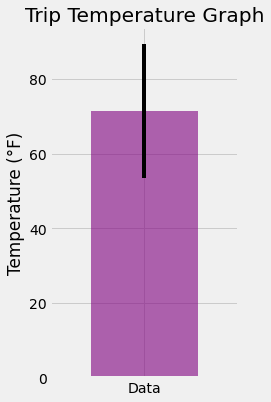

In [56]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
x = "Data"
y = trip_temp[0][1]
error = trip_temp[0][2] - trip_temp[0][0]
plt.figure(figsize=(3,6))
plt.bar(x, y, yerr=error, color="purple", alpha=0.6)
plt.xlim(-0.7,0.7)
plt.ylabel("Temperature (°F)")
plt.title("Trip Temperature Graph")
plt.show()

In [63]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]
trip_prcp = session.query(*sel).filter(Station.station == Measurement.station).filter(Measurement.date >= startdate).\
    filter(Measurement.date <= enddate).group_by(Station.station).order_by(func.sum(Measurement.prcp).desc()).all()
trip_prcp_df = pd.DataFrame(trip_prcp, columns=["Station", "Name", "Latitude", "Longitude", "Elevation", "Precipitation"])
trip_prcp_df
#thats a lot of rain... bad dates that i picked for vacation...

,Station,Name,Latitude,Longitude,Elevation,Precipitation
0,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,5.85
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,5.77
2,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,5.68
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,4.98
4,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,3.01
5,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,2.87
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.00


In [64]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [69]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
#using the same dates i used as previous part

# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
startstip = dt.datetime.strptime(startdate, "%Y-%m-%d")
endstip = dt.datetime.strptime(enddate, "%Y-%m-%d")

# Loop through the list of %m-%d strings and calculate the normals for each date
date_to_add = startstip
date_list = []
normals = []
while (endstip >=date_to_add):
    date_list.append(dt.datetime.strftime(date_to_add, "%Y-%m-%d"))
    normals.append(daily_normals(dt.datetime.strftime(date_to_add, "%m-%d")))
    date_to_add = date_to_add + dt.timedelta(days=1)
    
normals

[[(56.0, 68.41666666666667, 76.0)],
 [(61.0, 69.25, 79.0)],
 [(60.0, 69.15789473684211, 78.0)],
 [(58.0, 70.36206896551724, 80.0)],
 [(62.0, 70.89473684210526, 79.0)],
 [(56.0, 70.28813559322033, 79.0)],
 [(59.0, 70.48214285714286, 76.0)],
 [(62.0, 70.47272727272727, 77.0)],
 [(63.0, 70.79629629629629, 77.0)],
 [(60.0, 69.33962264150944, 77.0)],
 [(63.0, 70.14035087719299, 76.0)]]

In [86]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normal_list = []
for normal in normals:
    normal_list.append((normal[0]))
    
triptemp_df = pd.DataFrame(normal_list, columns=["Min Temp", "Avg Temp", "Max Temp"])
triptemp_df["Date"] = date_list
triptemp_df = triptemp_df.set_index("Date")

triptemp_df

,Min Temp,Avg Temp,Max Temp
Date,,,
2017-02-10,56.0,68.416667,76.0
2017-02-11,61.0,69.250000,79.0
2017-02-12,60.0,69.157895,78.0
2017-02-13,58.0,70.362069,80.0
2017-02-14,62.0,70.894737,79.0
2017-02-15,56.0,70.288136,79.0
2017-02-16,59.0,70.482143,76.0
2017-02-17,62.0,70.472727,77.0
2017-02-18,63.0,70.796296,77.0


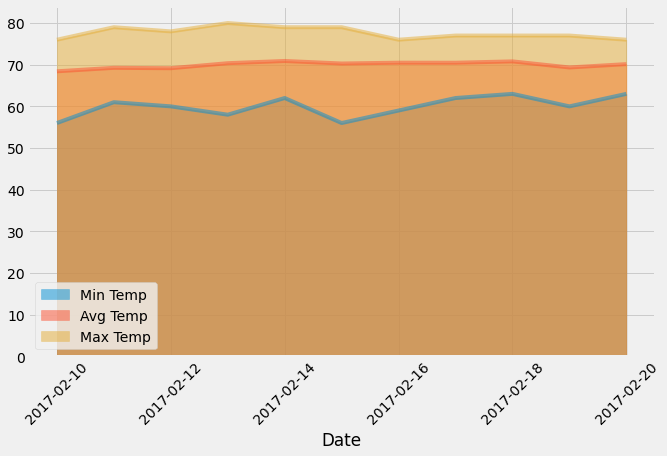

In [91]:
# Plot the daily normals as an area plot with `stacked=False`
triptemp_df.plot.area(stacked=False, figsize=(10,6))
plt.xticks(rotation="45")
plt.show()

In [98]:
#T-Test portion of Bonus
import scipy.stats as stats
sel = [Measurement.date, func.avg(Measurement.prcp)]

june = session.query(*sel).filter(func.strftime("%m", Measurement.date) == "06").group_by(Measurement.date).all()
june_df = pd.DataFrame(june, columns=["Date", "prcp"])
june_df.set_index("Date", inplace=True)

dec = session.query(*sel).filter(func.strftime("%m", Measurement.date) == "12").group_by(Measurement.date).all()
dec_df = pd.DataFrame(dec, columns=["Date", "prcp"])
dec_df.set_index("Date", inplace=True)

stats.ttest_ind(june_df["prcp"], dec_df["prcp"], equal_var=False)

Ttest_indResult(statistic=-2.3525715274933607, pvalue=0.019296449245981607)

In [ ]:
# we let null hypothesis be there is no significant difference in the temperature between June and December tobs data.
# according to the independent t-test, because p-value is less than 0.05, we reject the null hypothesis.
# this conclude that there IS a significant difference in the temperature between the 2 months.